# Identifying Regions of Interest

Sample walk-through for our ROI method. For more details visit https://medium.com/@kenan.r.alkiek/https-medium-com-kenan-r-alkiek-traffic-light-recognition-505d6ab913b1

### Starting Image

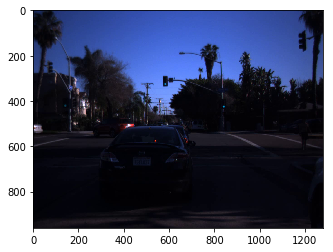

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, sys, inspect
from skimage.exposure import rescale_intensity

# Add tl-detector to path so I can import from the project
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir + '/src/') 

image = cv2.imread('../samples/0.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

### Cutoff the Lower Half and Convert to Grayscale

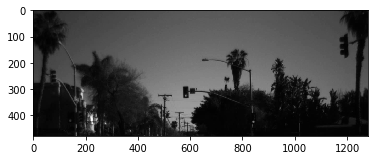

In [3]:
from helpers import cutoff_lower

image = cutoff_lower(image, 0.5)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_image, cmap='gray')
plt.show()

### Top-hat Morphology and Thresholding

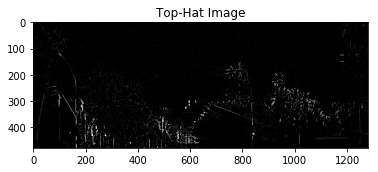

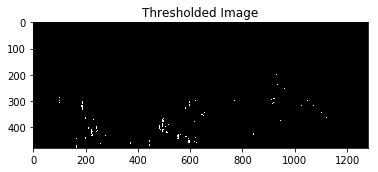

In [8]:
# Settings
kernel = np.ones((9, 9), dtype=int)
threshold = image.max() / 4

tophat_image = cv2.morphologyEx(gray_image, cv2.MORPH_TOPHAT, kernel)
ret, thresh = cv2.threshold(tophat_image, threshold, 255, cv2.THRESH_BINARY)

plt.title("Top-Hat Image")
plt.imshow(tophat_image, cmap='gray')
plt.show()

plt.title("Thresholded Image")
plt.imshow(thresh, cmap='gray')
plt.show()

### Watershed

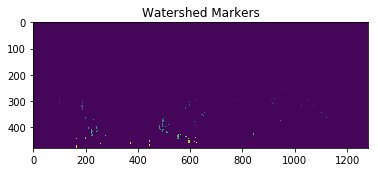

In [9]:
# Watershed region growing algorithm with the spotlights as the seeds
dist_transform = cv2.distanceTransform(np.uint8(thresh), cv2.DIST_L2, 5)
ret, markers = cv2.connectedComponents(np.uint8(dist_transform))

# Make sure the background is not 0
markers += 1

watershed_image = cv2.watershed(image, markers)

plt.title("Watershed Markers")
plt.imshow(watershed_image)
plt.show()

### Return Spotlights That Did Not Grow Too Large

In [10]:
max_size = 300

# Grab the marker values and how many times they occur
values, counts = np.unique(watershed_image, return_counts=True)

# Get the indices of where the segments are under the max size
segment_indices = np.where(counts <= max_size)
markers = values[segment_indices]

# Get the median coordinates of the markers (roughly the center)
coordinates = []
for marker in markers:
    y_coordinates, x_coordinates = np.where(watershed_image == marker)
    coordinates.append((int(np.median(x_coordinates)), int(np.median(y_coordinates))))
    
print("Number of windows found: {}".format(len(coordinates)))

Number of windows found: 121


## Final Result

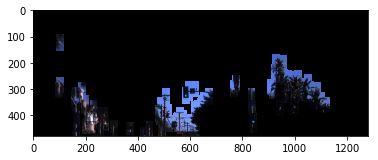

In [11]:
def display_roi(image, coordinates, window_size):
    mask = np.zeros(image.shape, dtype=np.uint8)
    x_offset = int((window_size[0] - 1) / 2)
    y_offset = int((window_size[1] - 1) / 2)

    for (x, y) in coordinates:
        x_min, x_max = x - x_offset, x + x_offset
        y_min, y_max = y - y_offset, y + y_offset
        mask[y_min:y_max, x_min:x_max] = 1

    display_img = np.zeros(image.shape, dtype=np.uint8)
    display_img[mask == 1] = image[mask == 1]

    plt.imshow(display_img, cmap='gray')
    plt.show()
    
display_roi(image, coordinates, window_size=(32, 64))

I ran this method on 25,000 images from the LISA traffic light dataset. For lights that were unobscured the recall rate was ~95%